# Анализа радова о COVID-19

У овом изазову наставићемо са темом пандемије COVID-а и фокусирати се на обраду научних радова на ту тему. Постоји [CORD-19 скуп података](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) са више од 7000 радова (у тренутку писања) о COVID-у, доступних са метаподацима и апстрактима (а за отприлике половину њих доступан је и цео текст).

Цео пример анализе овог скупа података користећи когнитивну услугу [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) описан је [у овом блог посту](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Ми ћемо размотрити поједностављену верзију ове анализе.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Преузимање података

Прво, потребно је да преузмемо метаподатке за CORD радове са којима ћемо радити.

**НАПОМЕНА**: Не пружамо копију скупа података као део овог репозиторијума. Можда ћете прво морати да преузмете датотеку [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) са [овог скупа података на Kaggle-у](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Можда ће бити потребна регистрација на Kaggle. Такође можете преузети скуп података без регистрације [овде](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), али ће укључивати све пуне текстове поред датотеке са метаподацима.

Покушаћемо да преузмемо податке директно са онлајн извора, међутим, ако то не успе, потребно је да преузмете податке на начин описан изнад. Такође, има смисла преузети податке ако планирате даље експериментисање са њима, како бисте уштедели време чекања.

> **НАПОМЕНА** да је скуп података прилично велик, око 1 ГБ, и следећи ред кода може потрајати дуго да се изврши! (~5 минута)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Сада ћемо конвертовати колону са датумом објављивања у `datetime` и нацртати хистограм како бисмо видели распон датума објављивања.


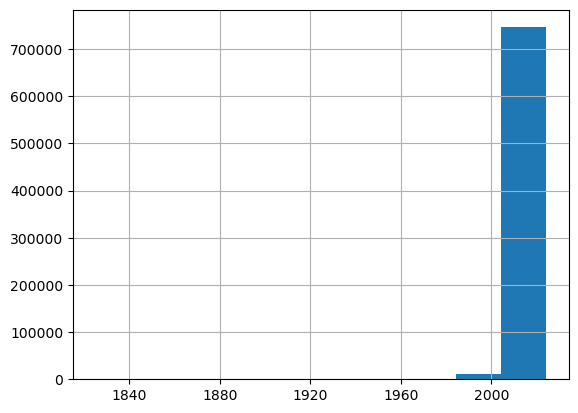

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Извлачење структурираних података

Хајде да видимо какве информације можемо лако извући из апстраката. Једна од ствари која би нас могла занимати јесте да видимо које стратегије лечења постоје и како су се оне развијале током времена. За почетак, можемо ручно саставити листу могућих лекова који се користе за лечење COVID-а, као и листу дијагноза. Затим их прегледамо и тражимо одговарајуће термине у апстрактима радова.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Додали смо неколико колона у наш dataframe које садрже број појављивања одређеног лека/дијагнозе у апстракту.

> **Напомена** да додајемо размак на почетак речи када тражимо подниску. Ако то не урадимо, можемо добити погрешне резултате, јер би *chloroquine* био пронађен и у подниски *hydroxychloroquine*. Такође, приморавамо конверзију колоне апстракта у `str` како бисмо избегли грешку - покушајте да уклоните `str` и видите шта ће се десити.

Да бисмо олакшали рад са подацима, можемо издвојити под-фрејм који садржи само бројеве појављивања лекова и израчунати укупан број појављивања. Ово нам даје најпопуларнији лек:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

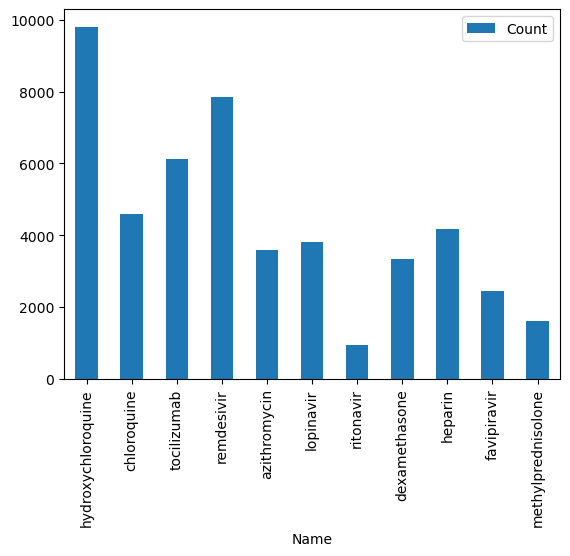

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Тражење трендова у стратегији лечења

У горњем примеру смо израчунали `sum` за све вредности, али можемо исто урадити и на месечном нивоу:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

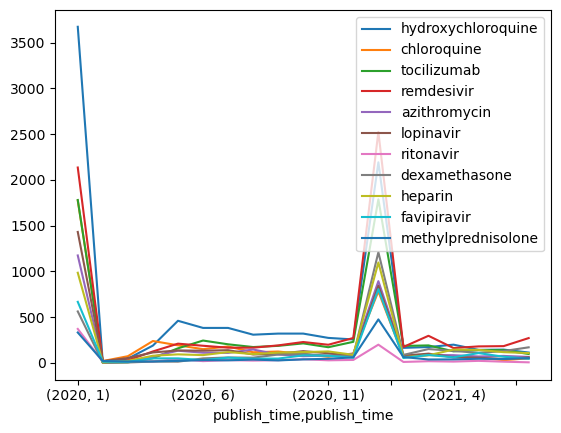

In [152]:
dfmt.plot()
plt.show()

Интересно је приметити да имамо огромне скокове на две локације: јануар 2020. и јануар 2021. То је узроковано чињеницом да неки радови немају јасно наведене датуме објављивања, па су означени као јануар одговарајуће године.

Да бисмо боље разумели податке, хајде да визуализујемо само неколико лекова. Такође ћемо "избрисати" податке за јануар и попунити их неком средњом вредношћу, како бисмо добили лепши графикон:


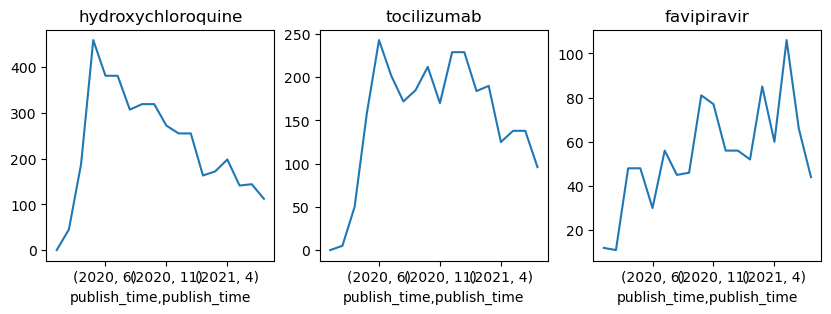

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

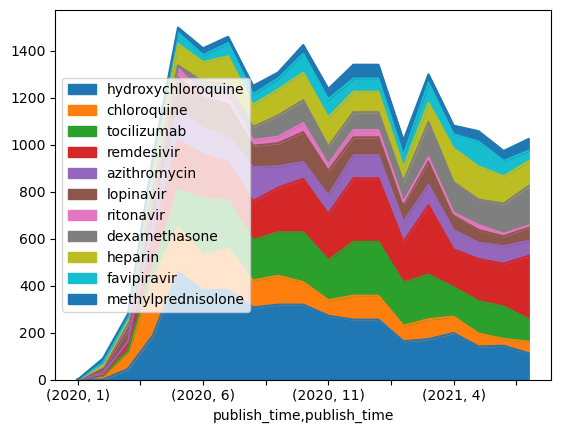

In [154]:
dfmt.plot.area()
plt.show()

Чак даље, можемо израчунати релативну популарност у процентима:


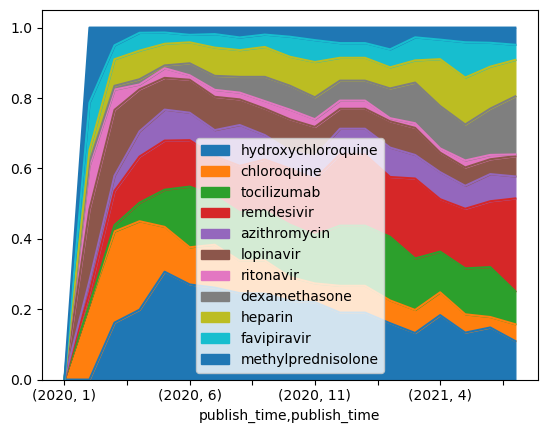

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Рачунарска кореспонденција између лекова и дијагноза

Један од најзанимљивијих односа који можемо истражити је како се различите дијагнозе лече различитим лековима. Да бисмо то визуализовали, потребно је израчунати **мапу учесталости ко-појављивања**, која ће показати колико пута се два термина помињу у истом раду.

Оваква мапа је у суштини 2Д матрица, која се најбоље представља помоћу **numpy array**. Ову мапу ћемо израчунати тако што ћемо пролазити кроз све апстракте и обележавати ентитете који се тамо појављују:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Један од начина да визуализујете ову матрицу је да нацртате **топлотну мапу**:


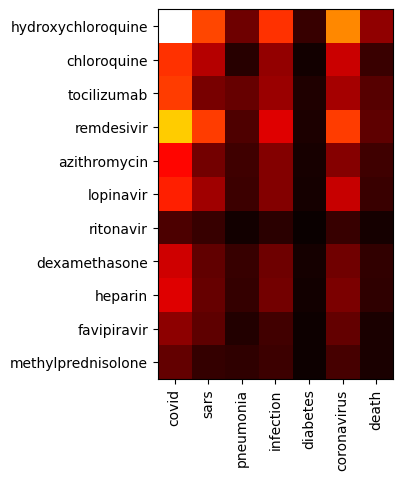

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Међутим, још боља визуализација може се постићи коришћењем такозваног **Санкеј** дијаграма! `matplotlib` нема уграђену подршку за овај тип дијаграма, па ћемо морати да користимо [Plotly](https://plotly.com/python/) као што је описано [у овом туторијалу](https://plotly.com/python/sankey-diagram/).

Да бисмо направили Санкеј дијаграм помоћу Plotly-а, потребно је да изградимо следеће листе:
* Листу `all_nodes` са свим чворовима у графику, која ће укључивати и лекове и дијагнозе
* Листу индекса извора и одредишта - те листе ће показивати који чворови иду на леву, а који на десну страну дијаграма
* Листу свих веза, при чему свака веза садржи:
   - Индекс извора у низу `all_nodes`
   - Индекс одредишта
   - Вредност која указује на јачину везе. Ово је управо вредност из наше матрице ко-јављања.
   - Опционо боју везе. Додаћемо опцију да истакнемо неке од термина ради јасноће.

Генерални код за цртање Санкеј дијаграма структуриран је као посебна функција `sankey`, која прихвата две листе (категорије извора и одредишта) и матрицу ко-јављања. Такође нам омогућава да одредимо праг и изоставимо све везе које су слабије од тог прага - ово чини дијаграм мало мање сложеним.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Закључак

Видели сте да можемо користити прилично једноставне методе за извлачење информација из неструктурираних извора података, као што је текст. У овом примеру, користили смо постојећу листу лекова, али би било много моћније користити технике обраде природног језика (NLP) за извлачење ентитета из текста. У [овом блогу](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) описујемо како користити cloud услуге за извлачење ентитета. Друга опција би била коришћење Python NLP библиотека као што је [NLTK](https://www.nltk.org/) - приступ за извлачење информација из текста помоћу NLTK је описан [овде](https://www.nltk.org/book/ch07.html).


## Изазов

Наставите истраживање података из радова о COVID-у у следећим правцима:

1. Направите матрицу ко-јављања различитих лекова и проверите који се лекови често јављају заједно (тј. помињу се у истом апстракту). Можете модификовати код за прављење матрице ко-јављања за лекове и дијагнозе.
1. Визуализујте ову матрицу користећи топлотну мапу.
1. Као додатни изазов, можете покушати да визуализујете ко-јављање лекова користећи [chord дијаграм](https://en.wikipedia.org/wiki/Chord_diagram). [Ова библиотека](https://pypi.org/project/chord/) може вам помоћи да нацртате chord дијаграм.
1. Као још један додатни изазов, покушајте да извучете дозе различитих лекова (као што је **400mg** у *узмите 400mg хлорокина дневно*) користећи регуларне изразе, и направите dataframe који приказује различите дозе за различите лекове. **Напомена**: узмите у обзир нумеричке вредности које се налазе у блиском текстуалном окружењу имена лека.



---

**Одрицање од одговорности**:  
Овај документ је преведен коришћењем услуге за превођење помоћу вештачке интелигенције [Co-op Translator](https://github.com/Azure/co-op-translator). Иако настојимо да обезбедимо тачност, молимо вас да имате у виду да аутоматски преводи могу садржати грешке или нетачности. Оригинални документ на изворном језику треба сматрати меродавним извором. За критичне информације препоручује се професионални превод од стране људи. Не сносимо одговорност за било каква погрешна тумачења или неспоразуме који могу произаћи из коришћења овог превода.
